# Random forest and XGBoost model for binary black holes


### IMPORTANT NOTE: 
- This is one the copies of the code run on the full csv file, it excludes in particular two features previously included (GWtime and Temperature) and additionally it balances the number of merging (40%) and non-merging (60%) binary systems given to the algorithms
- In this code, the initial conditions are the ones at the beginning of phase 1 (this code is trying to completly avoid the need for a BSE simulation) 

In [1]:
import pandas as pd
import random
import numpy as np
from numpy import loadtxt
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.utils import shuffle
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("merged_outputs.csv")

#### READING OUTPUT.CSV FILE
For binary systems the stellar properties are placed before the binary properties. The name of the stellar properties columns have a suffix _0 or _1 for the primary and secondary star, respectively. <br>
The columns in the output csv file are:

0. ID: ID of that binary system (it corresponds to its position in the input file) 
1. Name: unique identifier of the system, randomly drawn at the beginning of the evolution 
2. Mass_0: total mass of the star in Msun
3. MHE_0: mass of the Helium core of the star in Msun
4. MCO_0: mass of the Carbon/Oxigen core of the star in Msun
5. Radius_0: radius of the star in Rsun 
6. RHE_0: radius of Helium core in Rsun         
7. RCO_0: radius of the Carbon/Oxigen core in Rsun          
8. Luminosity_0: luminosity of the star in Lsun   
9. Temperature_0: effective temperature  of the star in Kelvin (temperature of a black body that would emit the same total amount of electromagnetic radiation.
10. Lambda_0: unused in this project    
11. Phase_0: SEVN stellar phase (phase of the simulation, number from 1 to 7)       
12. PhaseBSE_0:    
13. RemnantType_0: type of the final product of the stellar life (black hole/neutron star/white dwarf) 
14. Zams_0:    

(15 - 27) Same properties for the second star 

28. Semimajor: orbital semimajor axis of the binary in Rsun
29. Eccentricity: orbital eccentricity of the binary 
30. GWtime: in Myr        
31. BWolrdtime: time elapsed in the simulations in Myr (starting always from 0)
32. BEvent:


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11405940 entries, 0 to 11405939
Data columns (total 34 columns):
 #   Column         Dtype  
---  ------         -----  
 0   Unnamed: 0     int64  
 1   ID             int64  
 2   name           object 
 3   Mass_0         float64
 4   MHE_0          float64
 5   MCO_0          float64
 6   Radius_0       float64
 7   RHE_0          float64
 8   RCO_0          float64
 9   Luminosity_0   float64
 10  Temperature_0  float64
 11  Lambda_0       float64
 12  Phase_0        int64  
 13  PhaseBSE_0     float64
 14  RemnantType_0  int64  
 15  Zams_0         float64
 16  Mass_1         float64
 17  MHE_1          float64
 18  MCO_1          float64
 19  Radius_1       float64
 20  RHE_1          float64
 21  RCO_1          float64
 22  Luminosity_1   float64
 23  Temperature_1  float64
 24  Lambda_1       float64
 25  Phase_1        int64  
 26  PhaseBSE_1     float64
 27  RemnantType_1  int64  
 28  Zams_1         float64
 29  Semimajor   

In [4]:
df.describe()

,Unnamed: 0,ID,Mass_0,MHE_0,MCO_0,Radius_0,RHE_0,RCO_0,Luminosity_0,Temperature_0,...,Lambda_1,Phase_1,PhaseBSE_1,RemnantType_1,Zams_1,Semimajor,Eccentricity,GWtime,BWorldtime,BEvent
count,1.140594e+07,1.140594e+07,1.101501e+07,1.101501e+07,1.101501e+07,1.101501e+07,1.101501e+07,1.101501e+07,1.101501e+07,1.101501e+07,...,3.379834e+06,1.140594e+07,1.140594e+07,1.140594e+07,1.140594e+07,8.929772e+06,8.929772e+06,8.929772e+06,1.140594e+07,1.140594e+07
mean,5.702970e+06,5.001094e+05,9.907307e+00,2.290187e+00,3.901745e-01,5.262284e+01,5.204316e-01,1.044170e-02,9.264498e+04,1.067243e+05,...,7.882656e-01,2.759363e+00,3.757750e+00,6.346868e-03,9.212906e+00,4.975743e+03,1.846735e-01,1.016522e+20,5.352121e+01,1.487364e+00
std,3.292611e+06,2.886388e+05,1.582470e+01,7.719818e+00,3.418105e+00,1.725626e+02,4.864518e+00,5.090469e-02,4.310298e+05,2.989568e+05,...,7.762265e-01,2.278677e+00,4.681663e+00,7.574085e-01,1.139680e+01,7.860896e+04,2.249166e-01,8.116165e+21,8.218948e+01,3.316219e+00
min,0.000000e+00,0.000000e+00,3.122491e-01,0.000000e+00,0.000000e+00,1.278428e-05,0.000000e+00,0.000000e+00,1.000000e-10,5.569800e+02,...,1.257552e-01,1.000000e+00,1.000000e+00,-1.000000e+00,3.600008e-01,2.947162e-02,0.000000e+00,2.331601e-05,0.000000e+00,-1.000000e+00
25%,2.851485e+06,2.501660e+05,1.193223e+00,0.000000e+00,0.000000e+00,7.079578e-03,0.000000e+00,0.000000e+00,9.024713e-02,1.541861e+04,...,5.000000e-01,1.000000e+00,1.000000e+00,0.000000e+00,3.727440e+00,2.309002e+01,7.699887e-03,1.408322e+05,1.028574e+01,0.000000e+00
50%,5.702970e+06,5.001290e+05,5.314675e+00,8.072019e-08,0.000000e+00,3.750035e-01,3.086640e-08,0.000000e+00,2.048564e+03,2.828194e+04,...,5.986290e-01,1.000000e+00,1.000000e+00,0.000000e+00,5.849900e+00,8.595155e+01,9.610000e-02,1.840863e+07,3.026579e+01,0.000000e+00
75%,8.554454e+06,7.500910e+05,1.181128e+01,1.650859e+00,0.000000e+00,9.130722e+00,2.492864e-01,0.000000e+00,2.013534e+04,6.694708e+04,...,9.989920e-01,4.000000e+00,4.000000e+00,0.000000e+00,9.730700e+00,1.297362e+03,2.753994e-01,4.115902e+11,6.352431e+01,3.000000e+00
max,1.140594e+07,9.999990e+05,2.967587e+02,2.166298e+02,1.991020e+02,2.366384e+03,1.367179e+02,1.413096e+00,1.275851e+07,6.756760e+06,...,1.000000e+02,7.000000e+00,1.500000e+01,6.000000e+00,1.490212e+02,1.244851e+08,9.999964e-01,2.230152e+25,8.727068e+02,1.700000e+01


## DATA PREPROCESSING

First of all, we keep only the phase 7 of the simulation, when the two stars have become remnants.
A remnant is the final product of the stellar life: it could be a black hole, a neutron star or a white dwarf. 


In [5]:
print("Even if the number of first star remnant rows:", len(df['Phase_0']==7))
print("Is the same of second star remnant rows:", len(df['Phase_1']==7))
print("The two resulting dataframes wouldn't be equal: pd.equals =", (df['Phase_0']==7).equals(df['Phase_1']==7))
print("Having",len((df['Phase_0']==7).compare(df['Phase_1']==7)), "different rows")

Even if the number of first star remnant rows: 11405940
Is the same of second star remnant rows: 11405940
The two resulting dataframes wouldn't be equal: pd.equals = False
Having 4775604 different rows


So, as expected, we have to impose the condition about phase 7 on both stars.

In [6]:
display(len(df['Phase_0']==7))
df_7 = df[(df['Phase_0']==7) & (df['Phase_1']==7)]
print('Number of first star remnant rows:', len(df['Phase_0']==7))
print('Number of second star remnant rows:', len(df['Phase_1']==7))
print('Number of systems in which both stars are now remnants:', len(df_7))

11405940

Number of first star remnant rows: 11405940
Number of second star remnant rows: 11405940
Number of systems in which both stars are now remnants: 836441


Then we select the first row and the last row of the dataframe, creating two different subdataframes. 

In [7]:
new_df_initial = df.groupby('ID').first().reset_index()
new_df_last = df_7.groupby('ID').last().reset_index()
print(len(new_df_initial))
print(len(df.groupby('ID').last().reset_index()))
print(len(new_df_last))

836441
836441
836441


The "new_df_last" dataframe is useful to create the final "merging/non merging" label that will be appended to the "new_df_initial" dataframe as its new last column. Selecting only the rows with RemnantType_0 and RemnantType_1 both equal to 6 keeps only the binary systems finally composed by two black holes (a binary black hole -BBH-).

In [8]:
new_df_last.loc[ (new_df_last['RemnantType_0'] == 6) & (new_df_last['RemnantType_1'] == 6), 'bbh' ]=1
new_df_last.loc[ (new_df_last['RemnantType_0'] != 6) | (new_df_last['RemnantType_1'] != 6), 'bbh' ]=0

print('Number of binary black holes:', len(new_df_last[new_df_last['bbh']==1]))
print('Number of systems of a different kind:', len(new_df_last[new_df_last['bbh']==0]))


Number of binary black holes: 43617
Number of systems of a different kind: 792824


This is the last step to create the label: the "GWtime" column value for that row should be less that the lifetime of the universe in Myr (13700.0 Myr). This means that that BBH is able to merge in due time. <br>
The column values above this threshold and the column values equal to Nan are instead linked to non merging systems: the first ones are too slow, the second ones are not a BBH anymore at the end of the simulation.

In [9]:
new_df_last['mrg/nonmrg'] = 0
new_df_last.loc[ new_df_last['GWtime']  < 13700.0 , 'mrg/nonmrg' ]=1 #merging

print('Number of merging systems:', len(new_df_last[new_df_last['mrg/nonmrg']==1]))
print('Number of non merging systems:', len(new_df_last[new_df_last['mrg/nonmrg']==0]))
print('Number of Nans check:',new_df_last['mrg/nonmrg'].isna().values.sum())

Number of merging systems: 36858
Number of non merging systems: 799583
Number of Nans check: 0


Here we append the "mrg/nonmrg" labels obtained from the "new_df_last" dataframe to the "new_df_initial" dataframe. We decided to discard all the systems that are not BBH.

In [10]:
labels = new_df_last.loc[:,['mrg/nonmrg','bbh']]
final_data = pd.concat([new_df_initial, labels], axis=1)
final_data_bbh = final_data[final_data['bbh']==1]
final_data_bbh.drop(columns="bbh", inplace=True)

Now we have the final dataframe ("final_data_bbh"), the one that we will give to the machine learning algorithms.

In [11]:
final_data_bbh.head(10)

,ID,Unnamed: 0,name,Mass_0,MHE_0,MCO_0,Radius_0,RHE_0,RCO_0,Luminosity_0,...,Phase_1,PhaseBSE_1,RemnantType_1,Zams_1,Semimajor,Eccentricity,GWtime,BWorldtime,BEvent,mrg/nonmrg
17,22,6845396,0_176896908826503,119.23150,0.0,0.0,12.566040,0.0,0.0,1703093.0,...,1,1.0,0,46.7924,54.90501,0.0177,1.469804e+03,0.0,-1,1
94,116,6846397,0_657068005842330,37.26079,0.0,0.0,6.594214,0.0,0.0,193654.6,...,1,1.0,0,18.2395,396.53990,0.0720,9.651152e+07,0.0,-1,0
108,132,6846583,0_550951566446625,33.25268,0.0,0.0,6.215970,0.0,0.0,149194.6,...,1,1.0,0,23.4867,8598.16500,0.3119,1.292550e+13,0.0,-1,0
117,141,6846704,0_770606230539095,91.22868,0.0,0.0,10.786850,0.0,0.0,1104937.0,...,1,1.0,0,42.9523,36.92047,0.0223,5.290812e+02,0.0,-1,1
121,148,6846766,0_663735736747492,30.89447,0.0,0.0,5.942623,0.0,0.0,126127.2,...,1,1.0,0,23.7832,919.97300,0.2312,2.205787e+09,0.0,-1,0
138,166,6846994,0_128178925369444,31.25988,0.0,0.0,5.985497,0.0,0.0,129559.5,...,1,1.0,0,20.4904,503.26950,0.1185,2.761595e+08,0.0,-1,0
140,169,6847026,0_269541901132273,36.05127,0.0,0.0,6.498271,0.0,0.0,179508.1,...,1,1.0,0,31.2844,232.98450,0.2953,4.227822e+06,0.0,-1,0
145,174,6847111,0_267690239111620,80.34259,0.0,0.0,10.236460,0.0,0.0,872657.0,...,1,1.0,0,45.4771,199.10090,0.4432,2.384662e+05,0.0,-1,0
150,179,6847198,0_141004598564401,84.50295,0.0,0.0,10.442410,0.0,0.0,959626.1,...,1,1.0,0,78.0694,73758.13000,0.1857,3.661859e+15,0.0,-1,0
152,181,6847224,0_786680202494961,50.62208,0.0,0.0,7.749824,0.0,0.0,367926.7,...,1,1.0,0,20.1763,142.96720,0.6159,1.631719e+05,0.0,-1,0


In [12]:
final_data_bbh.columns

Index(['ID', 'Unnamed: 0', 'name', 'Mass_0', 'MHE_0', 'MCO_0', 'Radius_0',
       'RHE_0', 'RCO_0', 'Luminosity_0', 'Temperature_0', 'Lambda_0',
       'Phase_0', 'PhaseBSE_0', 'RemnantType_0', 'Zams_0', 'Mass_1', 'MHE_1',
       'MCO_1', 'Radius_1', 'RHE_1', 'RCO_1', 'Luminosity_1', 'Temperature_1',
       'Lambda_1', 'Phase_1', 'PhaseBSE_1', 'RemnantType_1', 'Zams_1',
       'Semimajor', 'Eccentricity', 'GWtime', 'BWorldtime', 'BEvent',
       'mrg/nonmrg'],
      dtype='object')

## COMMON LAST PREPROCESSING STEPS
We select the significative columns, divide the input data from the labels and split it all in training set (70%) and test set (30%). We also plot a heatmap with the aim to get a glimpse of the eventual direct or inverse correlations between the selected features.  

In [13]:
filtered_data = final_data_bbh.loc[:,['Mass_0','Mass_1','Radius_0','Radius_1', 'Luminosity_0', 
    'Luminosity_1', 'Semimajor', 'Eccentricity', 'mrg/nonmrg']]

<AxesSubplot:>

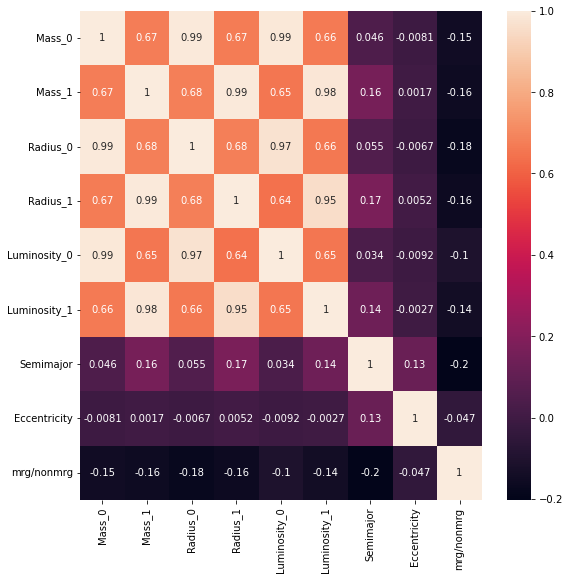

In [14]:
plt.figure(figsize=(9, 9))
sns.heatmap(filtered_data.corr(),annot=True)

In [15]:
mrg_bbh = filtered_data[filtered_data['mrg/nonmrg']==1]
nonmrg_bbh = filtered_data[filtered_data['mrg/nonmrg']==0]
print(len(mrg_bbh ),len(nonmrg_bbh ))


8151 35466


In [16]:
#mrg 40%, nonmrg 60%, mrg:nonmrg=1:1.5
num_nonmrg_bbh = int(len(mrg_bbh )*1.5)

#random choice in non black holes
idx = list(np.random.choice(np.arange(1,len(nonmrg_bbh)), num_nonmrg_bbh, replace=False))
nonmrg_bbh= nonmrg_bbh.iloc[idx,:]
print(len(mrg_bbh),len(nonmrg_bbh))

8151 12226


In [17]:
filtered_data = pd.concat([mrg_bbh,nonmrg_bbh])
filtered_data= shuffle(filtered_data)

<AxesSubplot:>

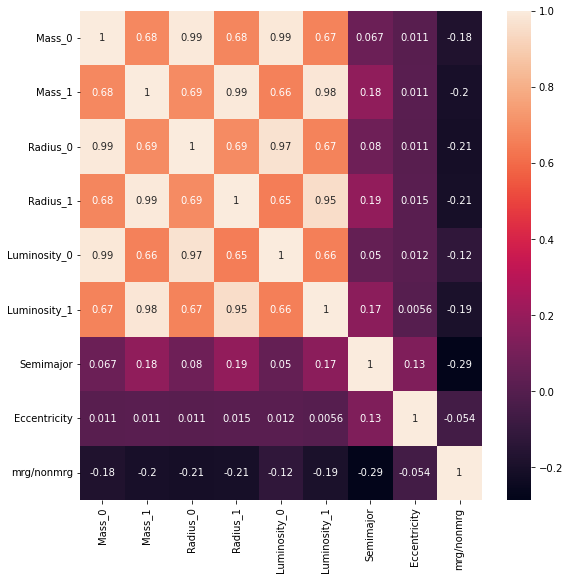

In [18]:
plt.figure(figsize=(9, 9))
sns.heatmap(filtered_data.corr(),annot=True)

In [19]:
X = filtered_data.iloc[:,:-1]
y = filtered_data.iloc[:,-1:]

In [20]:
X = X.fillna(0)
y = y.fillna(0)

In [21]:
seed = 7
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

## RANDOM FOREST

Random forest is an ensemble tool which takes a subset of observations and a subset of variables to build a decision trees. Moreover, Parameters in random forest are either to increase the predictive power of the model or to make it easier to train the model. For testing different parameters we are using the GridSearchCV.

GridSearchCV is a technique to search through the best parameter values from the given set of the grid of parameters. It is basically a cross-validation method. the model and the parameters are required to be fed in. Best parameter values are extracted and then the predictions are made.

different parameters for RandomForest MODEL:

n_estimators: This is the number of trees you want to build before taking the maximum voting or averages of predictions.(Higher number of trees give you better performance but makes your code slower)

max_features: These are the maximum number of features Random Forest is allowed to try in individual tree.

max_depth: The maximum depth of the tree.

criterion: The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “log_loss” and “entropy” both for the Shannon information gain.

In [22]:
rfc = RandomForestClassifier()

param_grid = { 
    'n_estimators': [100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [5,10,15,20,25],
    'criterion' :['gini', 'entropy']
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5, verbose=3)
CV_rfc.fit(X_train, y_train)
CV_rfc.best_params_

Fitting 5 folds for each of 90 candidates, totalling 450 fits
[CV 1/5] END criterion=gini, max_depth=5, max_features=auto, n_estimators=100;, score=0.875 total time=   1.7s
[CV 2/5] END criterion=gini, max_depth=5, max_features=auto, n_estimators=100;, score=0.865 total time=   1.5s
[CV 3/5] END criterion=gini, max_depth=5, max_features=auto, n_estimators=100;, score=0.884 total time=   1.1s
[CV 4/5] END criterion=gini, max_depth=5, max_features=auto, n_estimators=100;, score=0.868 total time=   0.9s
[CV 5/5] END criterion=gini, max_depth=5, max_features=auto, n_estimators=100;, score=0.873 total time=   1.1s
[CV 1/5] END criterion=gini, max_depth=5, max_features=auto, n_estimators=200;, score=0.872 total time=   2.2s
[CV 2/5] END criterion=gini, max_depth=5, max_features=auto, n_estimators=200;, score=0.865 total time=   1.9s
[CV 3/5] END criterion=gini, max_depth=5, max_features=auto, n_estimators=200;, score=0.885 total time=   2.0s
[CV 4/5] END criterion=gini, max_depth=5, max_feat

[CV 4/5] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=500;, score=0.914 total time=   6.9s
[CV 5/5] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=500;, score=0.912 total time=   6.9s
[CV 1/5] END criterion=gini, max_depth=10, max_features=log2, n_estimators=100;, score=0.925 total time=   1.9s
[CV 2/5] END criterion=gini, max_depth=10, max_features=log2, n_estimators=100;, score=0.914 total time=   1.9s
[CV 3/5] END criterion=gini, max_depth=10, max_features=log2, n_estimators=100;, score=0.929 total time=   1.8s
[CV 4/5] END criterion=gini, max_depth=10, max_features=log2, n_estimators=100;, score=0.920 total time=   1.8s
[CV 5/5] END criterion=gini, max_depth=10, max_features=log2, n_estimators=100;, score=0.920 total time=   1.9s
[CV 1/5] END criterion=gini, max_depth=10, max_features=log2, n_estimators=200;, score=0.926 total time=   3.8s
[CV 2/5] END criterion=gini, max_depth=10, max_features=log2, n_estimators=200;, score=0.913 total time=

[CV 3/5] END criterion=gini, max_depth=20, max_features=auto, n_estimators=500;, score=0.941 total time=   7.7s
[CV 4/5] END criterion=gini, max_depth=20, max_features=auto, n_estimators=500;, score=0.928 total time=   8.6s
[CV 5/5] END criterion=gini, max_depth=20, max_features=auto, n_estimators=500;, score=0.932 total time=   8.3s
[CV 1/5] END criterion=gini, max_depth=20, max_features=sqrt, n_estimators=100;, score=0.932 total time=   1.5s
[CV 2/5] END criterion=gini, max_depth=20, max_features=sqrt, n_estimators=100;, score=0.925 total time=   1.5s
[CV 3/5] END criterion=gini, max_depth=20, max_features=sqrt, n_estimators=100;, score=0.939 total time=   1.5s
[CV 4/5] END criterion=gini, max_depth=20, max_features=sqrt, n_estimators=100;, score=0.927 total time=   1.4s
[CV 5/5] END criterion=gini, max_depth=20, max_features=sqrt, n_estimators=100;, score=0.930 total time=   1.5s
[CV 1/5] END criterion=gini, max_depth=20, max_features=sqrt, n_estimators=200;, score=0.933 total time=

[CV 2/5] END criterion=gini, max_depth=25, max_features=log2, n_estimators=500;, score=0.927 total time=   9.6s
[CV 3/5] END criterion=gini, max_depth=25, max_features=log2, n_estimators=500;, score=0.944 total time=   9.7s
[CV 4/5] END criterion=gini, max_depth=25, max_features=log2, n_estimators=500;, score=0.932 total time=   9.7s
[CV 5/5] END criterion=gini, max_depth=25, max_features=log2, n_estimators=500;, score=0.938 total time=  10.7s
[CV 1/5] END criterion=entropy, max_depth=5, max_features=auto, n_estimators=100;, score=0.871 total time=   1.2s
[CV 2/5] END criterion=entropy, max_depth=5, max_features=auto, n_estimators=100;, score=0.864 total time=   1.2s
[CV 3/5] END criterion=entropy, max_depth=5, max_features=auto, n_estimators=100;, score=0.884 total time=   1.1s
[CV 4/5] END criterion=entropy, max_depth=5, max_features=auto, n_estimators=100;, score=0.867 total time=   1.1s
[CV 5/5] END criterion=entropy, max_depth=5, max_features=auto, n_estimators=100;, score=0.871 t

[CV 4/5] END criterion=entropy, max_depth=10, max_features=sqrt, n_estimators=200;, score=0.911 total time=   4.0s
[CV 5/5] END criterion=entropy, max_depth=10, max_features=sqrt, n_estimators=200;, score=0.911 total time=   3.9s
[CV 1/5] END criterion=entropy, max_depth=10, max_features=sqrt, n_estimators=500;, score=0.914 total time=   9.9s
[CV 2/5] END criterion=entropy, max_depth=10, max_features=sqrt, n_estimators=500;, score=0.904 total time=   9.8s
[CV 3/5] END criterion=entropy, max_depth=10, max_features=sqrt, n_estimators=500;, score=0.916 total time=   9.6s
[CV 4/5] END criterion=entropy, max_depth=10, max_features=sqrt, n_estimators=500;, score=0.910 total time=   9.7s
[CV 5/5] END criterion=entropy, max_depth=10, max_features=sqrt, n_estimators=500;, score=0.911 total time=   9.6s
[CV 1/5] END criterion=entropy, max_depth=10, max_features=log2, n_estimators=100;, score=0.921 total time=   2.5s
[CV 2/5] END criterion=entropy, max_depth=10, max_features=log2, n_estimators=10

[CV 1/5] END criterion=entropy, max_depth=20, max_features=auto, n_estimators=200;, score=0.932 total time=   4.6s
[CV 2/5] END criterion=entropy, max_depth=20, max_features=auto, n_estimators=200;, score=0.929 total time=   4.5s
[CV 3/5] END criterion=entropy, max_depth=20, max_features=auto, n_estimators=200;, score=0.939 total time=   4.5s
[CV 4/5] END criterion=entropy, max_depth=20, max_features=auto, n_estimators=200;, score=0.927 total time=   4.4s
[CV 5/5] END criterion=entropy, max_depth=20, max_features=auto, n_estimators=200;, score=0.937 total time=   4.3s
[CV 1/5] END criterion=entropy, max_depth=20, max_features=auto, n_estimators=500;, score=0.931 total time=  11.5s
[CV 2/5] END criterion=entropy, max_depth=20, max_features=auto, n_estimators=500;, score=0.925 total time=  11.4s
[CV 3/5] END criterion=entropy, max_depth=20, max_features=auto, n_estimators=500;, score=0.938 total time=  11.7s
[CV 4/5] END criterion=entropy, max_depth=20, max_features=auto, n_estimators=50

[CV 3/5] END criterion=entropy, max_depth=25, max_features=log2, n_estimators=100;, score=0.941 total time=   3.0s
[CV 4/5] END criterion=entropy, max_depth=25, max_features=log2, n_estimators=100;, score=0.932 total time=   3.0s
[CV 5/5] END criterion=entropy, max_depth=25, max_features=log2, n_estimators=100;, score=0.938 total time=   3.0s
[CV 1/5] END criterion=entropy, max_depth=25, max_features=log2, n_estimators=200;, score=0.936 total time=   6.4s
[CV 2/5] END criterion=entropy, max_depth=25, max_features=log2, n_estimators=200;, score=0.927 total time=   6.4s
[CV 3/5] END criterion=entropy, max_depth=25, max_features=log2, n_estimators=200;, score=0.942 total time=   6.1s
[CV 4/5] END criterion=entropy, max_depth=25, max_features=log2, n_estimators=200;, score=0.931 total time=   6.1s
[CV 5/5] END criterion=entropy, max_depth=25, max_features=log2, n_estimators=200;, score=0.940 total time=   6.1s
[CV 1/5] END criterion=entropy, max_depth=25, max_features=log2, n_estimators=50

{'criterion': 'entropy',
 'max_depth': 20,
 'max_features': 'log2',
 'n_estimators': 500}

Using "GridSearchCV.predict" directly will yield the same results as getting the best hyper-parameter through "GridSearchCV.best_param_" and then using it in the random forest classifier

In [23]:
y_pred=CV_rfc.predict(X_test)

Feature Selection using RandomForest:

The feature importance describes which features are relevant. It can help with better understanding of the solved problem and sometimes lead to model improvements by employing the feature selection.

<BarContainer object of 8 artists>

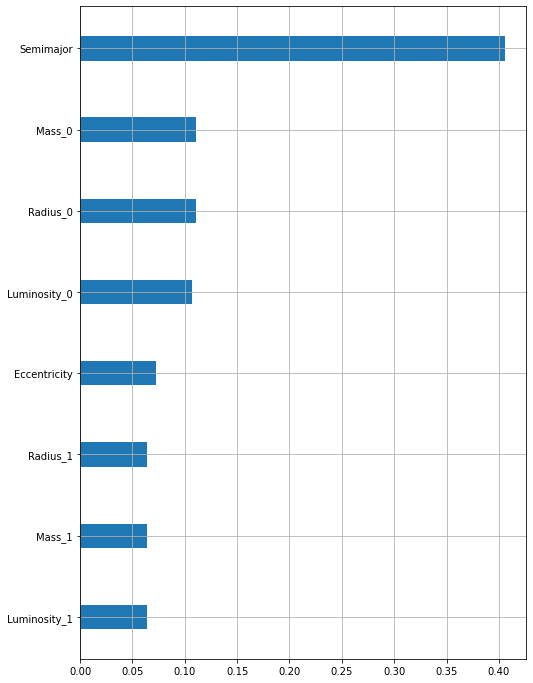

In [24]:
feat_imp_df = pd.DataFrame({"Feature":X.columns, "Importance": CV_rfc.best_estimator_.feature_importances_})
feat_imp_df_desc= feat_imp_df.sort_values("Importance",ascending=True)
plt.figure(figsize=(8, 12))
plt.grid()
plt.barh("Feature","Importance", data=feat_imp_df_desc, height=0.3)

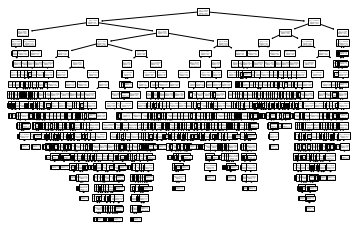

In [25]:
plot_tree(CV_rfc.best_estimator_.estimators_[0])
plt.show()

In [26]:
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9403009486424599


In [27]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      3683
           1       0.91      0.94      0.93      2431

    accuracy                           0.94      6114
   macro avg       0.94      0.94      0.94      6114
weighted avg       0.94      0.94      0.94      6114



In [28]:
#CONFUSION MATRIX 
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)

[[3453  230]
 [ 135 2296]]


## XGBoost model

XGBoost is a decision-tree-based ensemble Machine Learning algorithm that uses a gradient boosting framework. In prediction problems involving unstructured data (images, text, etc.) artificial neural networks tend to outperform all other algorithms or frameworks.

First of all, we convert the dataframes X and Y into an optimized data structure called Dmatrix that XGBoost supports, granting best performances (it improves both memory efficiency and training speed).

In [29]:
data_dmatrix = xgb.DMatrix(data=X,label=y) 

Let's set up a parameter grid that will be explored during the search.

different parameters for XGBoost MODEL:

learning_rate: step size shrinkage used to prevent overfitting. Range is [0,1]

colsample_bytree: percentage of features used per tree. High value can lead to overfitting.

max_depth: determines how deeply each tree is allowed to grow during any boosting round.

n_estimators: number of trees you want to build.

reg_alpha: L1 regularization term on weights. Increasing this value will make model more conservative

In [30]:
parameters = { 'colsample_bytree': [0.1,0.3,0.5,0.8,1],'learning_rate': [0.01,0.1,0.6,0.8,1], 'max_depth': [1,3,5,8,10], 'reg_alpha':[0] }

GridSearchCV is a library function that is a member of sklearn’s model_selection package. It helps us to loop through predefined hyperparameters and fit our estimator (model) on our training set. So, in the end, We can select the best parameters from the listed hyperparameters.

In [31]:
estimator = xgb.XGBClassifier(colsample_bytree = 0.8, learning_rate = 1,
                max_depth = 1, reg_alpha=0 , n_estimators = 50)
                # n_estimators = 50 means 50 trees

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 5,
    cv = 5,
    verbose=True
)

grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 125 candidates, totalling 625 fits
[15:12:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=1, max_delta_step=None,
                                     max_depth=1, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estim...,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=0,
                                     reg_lambda=None, scale_pos_weight=None,
                      

In [32]:
#Fit the regressor to the training set and make predictions on the test set using the familiar .fit() and .predict() methods

preds_2 = grid_search.predict(X_test)

In [33]:
grid_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.6, max_delta_step=0,
              max_depth=10, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Feature Selection using XGBoost:

Decision Tree-based methods like random forest, xgboost, rank the input features in order of importance and accordingly take decisions while classifying the data.

<Figure size 576x864 with 0 Axes>

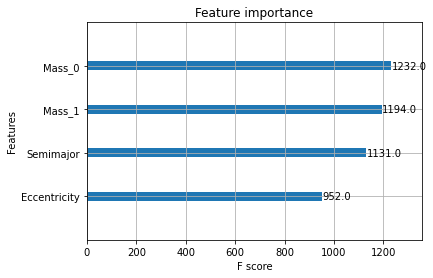

In [34]:
plt.figure(figsize=(8, 12))
xgb.plot_importance(grid_search.best_estimator_)
plt.rcParams['figure.figsize'] = [8, 12]
plt.show()

In this step we plot individual decision trees from a trained XGBoost gradient boosted model. Running the code creates a plot of the different decision tree in the model, showing the features and feature values for each split as well as the output leaf nodes.

In [35]:
#fig, tree = plt.subplots(figsize=(30, 30))
xgb_train = xgb.train(params=grid_search.best_params_, dtrain=data_dmatrix, num_boost_round=20)
xgb.plot_tree(xgb_train, num_trees=0)
#plt.rcParams['figure.figsize'] = [200, 200]
plt.show()

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.468864 to fit


In [36]:
xgb.plot_tree(xgb_train, num_trees=1)
plt.show()

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.420953 to fit


In [37]:
xgb.plot_tree(xgb_train, num_trees=2)
plt.show()

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.391931 to fit


In [38]:
xgb.plot_tree(xgb_train, num_trees=3)
plt.show()

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.421294 to fit


In [39]:
print(classification_report(y_test, preds_2))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      3683
           1       0.91      0.94      0.92      2431

    accuracy                           0.94      6114
   macro avg       0.93      0.94      0.93      6114
weighted avg       0.94      0.94      0.94      6114



In [40]:
#CONFUSION MATRIX 
cf_matrix_2 = confusion_matrix(y_test, preds_2)
print(cf_matrix_2)

[[3453  230]
 [ 154 2277]]


## RESULTS COMPARISON
Direct comparison between confusion matrices, accuracies, precisions, recalls and f1 scores from the random forest and from the XGBoost model. <br> 

accuracies: Classification accuracy is the total number of correct predictions divided by the total number of predictions made for a dataset.

Precision: Precision quantifies the number of positive class predictions that actually belong to the positive class.

Recall: Recall quantifies the number of positive class predictions made out of all positive examples in the dataset.

F-Measure: F-Measure provides a single score that balances both the concerns of precision and recall in one number.
The following function takes a confusion matrix as an argument and pretty prints all the results mentioned above.

In [41]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=(8,8),
                          cmap='Blues',
                          title=None):
   
    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [42]:
group_names = ['True Neg','False Pos','False Neg', 'True Pos']
categories = ['Zero', 'One']

Pretty printing of the results for the random forest:

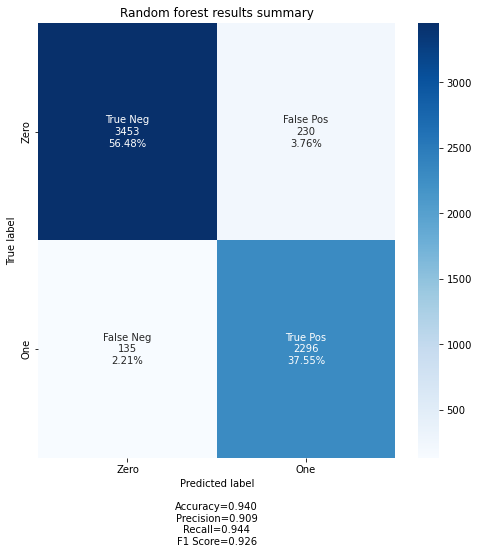

In [43]:
make_confusion_matrix(cf_matrix,
                      group_names=group_names,
                      categories=categories, 
                      cmap='Blues',
                      title="Random forest results summary")

Pretty printing of the results for the XGBoost model:

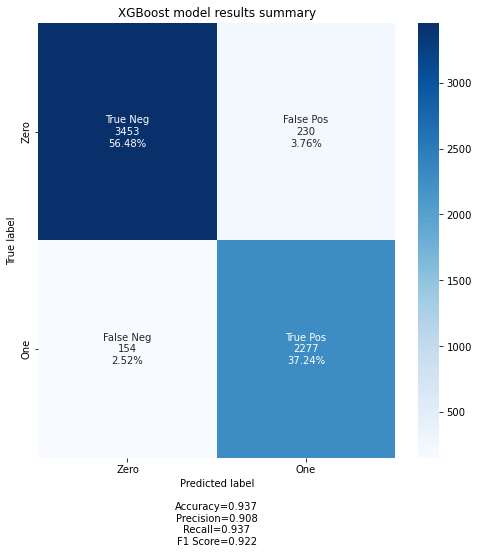

In [44]:
make_confusion_matrix(cf_matrix_2,
                      group_names=group_names,
                      categories=categories, 
                      cmap='Blues',
                      title="XGBoost model results summary")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4e6d886b-e60a-4c5b-ad77-020e7f429015' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>